# ROB701@MBZUAI Fall 2025 - Lab 1113

**TA:** Tianyu Liu  
**Email:** [Tianyu.Liu@mbzuai.ac.ae](mailto:Tianyu.Liu@mbzuai.ac.ae)

**Topic:** Manipulator trajectory generation.

Note: Read through and familiarize yourself with the related knowledge.

<img src="https://raw.githubusercontent.com/RealGaule/ROB701_Lab/842ab4e9851bc4fcc03271e134283e67db776383/docs/Robotics.png" width="320">

### Imports and Dependencies

This cell imports the core libraries used throughout the lab:
- `mujoco as mj` — physics engine API used to load the MJCF/MJXML model and step the simulation.
- `from mujoco import viewer` — the **official MuJoCo Viewer** used for visualization.
- `numpy`, `scipy.optimize.fsolve` — numerical computation and non-linear equation solving.
- `matplotlib.pyplot` — plotting utilities for joint trajectories.
- `types.SimpleNamespace` — a lightweight container to pass grouped values around.

In [1]:
import mujoco as mj
from mujoco import viewer
import numpy as np
import os
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from types import SimpleNamespace
import os

## Utility Function

### Rotation and Attitude Utilities

This cell defines a small rotation library used by kinematics and inverse-kinematics:
- **Axis rotations**: `rotation(angle, axis)` builds a rotation about the x/y/z axis.
- **Euler/Bryant angles** conversions: `rotation2euler`, `euler2rotation` (watch out for gimbal lock when $\cos\theta \approx 0$).
- **Quaternions**: normalization, quaternion $\leftrightarrow$ rotation matrix conversions.

**Key formulas**

- *Rodrigues' formula* for an axis–angle rotation $\mathbf{R}(\theta, \hat{u})$:
$$
\mathbf{R} = \mathbf{I} + \sin\theta\,[\hat{u}]_\times + (1-\cos\theta)\,[\hat{u}]_\times^2,
\qquad
[\hat{u}]_\times =
\begin{bmatrix}
0 & -u_z & u_y\\
u_z & 0 & -u_x\\
-u_y & u_x & 0
\end{bmatrix}.
$$

- *Quaternion to rotation* (with $q = [w,x,y,z],\ \|q\|=1$):
$$
\mathbf{R}(q)=\begin{bmatrix}
1-2(y^2+z^2) & 2(xy-wz) & 2(xz+wy)\\
2(xy+wz) & 1-2(x^2+z^2) & 2(yz-wx)\\
2(xz-wy) & 2(yz+wx) & 1-2(x^2+y^2)
\end{bmatrix}.
$$

- *Euler/Bryant angles*: the code implements consistent extract/compose functions; angles are returned in radians. Near singular configurations, prefer quaternion-based computations for numerical robustness.

All quaternion operations renormalize to unit length to ensure proper rotations.

In [2]:
import numpy as np

# For testing whether a number is close to zero
_FLOAT_EPS = np.finfo(np.float64).eps
_EPS4 = _FLOAT_EPS * 4.0


def rotation(angle, axis):
    c, s = np.cos(angle), np.sin(angle)
    if axis == 0:  # Rotation around x-axis
        return np.array([
            [1, 0, 0],
            [0, c, -s],
            [0, s, c]
        ])
    elif axis == 1:  # Rotation around y-axis
        return np.array([
            [c, 0, s],
            [0, 1, 0],
            [-s, 0, c]
        ])
    elif axis == 2:  # Rotation around z-axis
        return np.array([
            [c, -s, 0],
            [s, c, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError("Axis must be 0 (x), 1 (y), or 2 (z).")

import numpy as np

def quat2rotation(q):

    # Extract quaternion components
    q0, q1, q2, q3 = q

    # Compute the rotation matrix using the formula
    R = np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2 * (q1 * q2 - q0 * q3), 2 * (q1 * q3 + q0 * q2)],
        [2 * (q1 * q2 + q0 * q3), q0**2 - q1**2 + q2**2 - q3**2, 2 * (q2 * q3 - q0 * q1)],
        [2 * (q1 * q3 - q0 * q2), 2 * (q2 * q3 + q0 * q1), q0**2 - q1**2 - q2**2 + q3**2]
    ])

    return R

def rotation2quat(R):
    # Ensure R is a 3x3 matrix
    assert R.shape == (3, 3), "Input must be a 3x3 rotation matrix."

    # Calculate the magnitudes of q0, q1, q2, q3
    q0 = np.sqrt(1 + R[0, 0] + R[1, 1] + R[2, 2]) / 2
    q1 = np.sqrt(1 + R[0, 0] - R[1, 1] - R[2, 2]) / 2
    q2 = np.sqrt(1 - R[0, 0] + R[1, 1] - R[2, 2]) / 2
    q3 = np.sqrt(1 - R[0, 0] - R[1, 1] + R[2, 2]) / 2

    # Determine which magnitude is largest and compute the quaternion components
    if q0 >= max(q1, q2, q3):  # q0 is largest
        q1 = (R[2, 1] - R[1, 2]) / (4 * q0)
        q2 = (R[0, 2] - R[2, 0]) / (4 * q0)
        q3 = (R[1, 0] - R[0, 1]) / (4 * q0)
    elif q1 >= max(q0, q2, q3):  # q1 is largest
        q0 = (R[2, 1] - R[1, 2]) / (4 * q1)
        q2 = (R[1, 0] + R[0, 1]) / (4 * q1)
        q3 = (R[0, 2] + R[2, 0]) / (4 * q1)
    elif q2 >= max(q0, q1, q3):  # q2 is largest
        q0 = (R[0, 2] - R[2, 0]) / (4 * q2)
        q1 = (R[1, 0] + R[0, 1]) / (4 * q2)
        q3 = (R[2, 1] + R[1, 2]) / (4 * q2)
    else:  # q3 is largest
        q0 = (R[1, 0] - R[0, 1]) / (4 * q3)
        q1 = (R[0, 2] + R[2, 0]) / (4 * q3)
        q2 = (R[2, 1] + R[1, 2]) / (4 * q3)

    return np.array([q0, q1, q2, q3])

def quat2axisangle(quat):
    #q0 = cos(angle/2)
    #[qx,qy,qz] = sin(angle/2)*axis

    #angle = 2*acos(q0)
    #axis = (1/sin(angle/2))*[qx,qy,qz]

    q0 = quat[0]
    qx = quat[1]
    qy = quat[2]
    qz = quat[3]

    angle = 2*np.arccos(q0)
    sin_half_theta = np.sin(angle/2);

    if (sin_half_theta < 1e-6): #avoid division by zeros
        axis = np.array([1,0,0]) #this is just an arbitrary choice
    else:
        axis = (1/sin_half_theta)*np.array([qx,qy,qz])

    return axis,angle


def euler2rotation(euler):
    Rx = rotation(euler[0], 0)
    Ry = rotation(euler[1], 1)
    Rz = rotation(euler[2], 2)
    R = Rx@Ry
    R = R@Rz
    return R

def rotation2euler(R):
    r13 = R[0,2]
    theta = np.arcsin(r13); #sin(theta) = r13
    cos_theta = np.cos(theta)

    r12 = R[0,1]
    psi = np.arcsin(-r12/cos_theta) #sin(psi)*cos(theta) = -r12

    r23 = R[1,2]
    phi = np.arcsin(-r23/cos_theta) #sin(phi)*cos(theta) = -r23

    return np.array([phi,theta,psi])

def quat2euler(q):
    R = quat2rotation(q);
    euler = rotation2euler(R)

    return euler

def euler2quat(euler):
    R = euler2rotation(euler)
    quat = rotation2quat(R)
    return quat



def quat_product(q,p):
    q0 = q[0];
    p0 = p[0];
    p_vec = p[1:4].copy()
    q_vec = q[1:4].copy()
    qp0 = q0*p0-np.dot(p_vec,q_vec)
    qp_vec = q0*p_vec + p0*q_vec + np.cross(q_vec,p_vec)
    qp = np.array([qp0,qp_vec[0],qp_vec[1],qp_vec[2]])
    return qp

def quat_normalize(q):
    assert q.shape[-1] == 4
    norm = np.linalg.norm(q, axis=-1, keepdims=True)
    return q / norm  # Normalize each quaternion

def vec2skew(v):
    # Ensure v is a 3-element vector
    assert len(v) == 3, "Input must be a 3-element vector"

    # Create the skew-symmetric matrix
    V = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

    return V

# Taken from: https://github.com/openai/mujoco-worldgen/blob/master/mujoco_worldgen/util/rotation.py
def mat2quat(mat):
    """ Convert Rotation Matrix to Quaternion.  See rotation.py for notes """
    mat = np.asarray(mat, dtype=np.float64)
    assert mat.shape[-2:] == (3, 3), "Invalid shape matrix {}".format(mat)

    Qxx, Qyx, Qzx = mat[..., 0, 0], mat[..., 0, 1], mat[..., 0, 2]
    Qxy, Qyy, Qzy = mat[..., 1, 0], mat[..., 1, 1], mat[..., 1, 2]
    Qxz, Qyz, Qzz = mat[..., 2, 0], mat[..., 2, 1], mat[..., 2, 2]
    # Fill only lower half of symmetric matrix
    K = np.zeros(mat.shape[:-2] + (4, 4), dtype=np.float64)
    K[..., 0, 0] = Qxx - Qyy - Qzz
    K[..., 1, 0] = Qyx + Qxy
    K[..., 1, 1] = Qyy - Qxx - Qzz
    K[..., 2, 0] = Qzx + Qxz
    K[..., 2, 1] = Qzy + Qyz
    K[..., 2, 2] = Qzz - Qxx - Qyy
    K[..., 3, 0] = Qyz - Qzy
    K[..., 3, 1] = Qzx - Qxz
    K[..., 3, 2] = Qxy - Qyx
    K[..., 3, 3] = Qxx + Qyy + Qzz
    K /= 3.0
    # TODO: vectorize this -- probably could be made faster
    q = np.empty(K.shape[:-2] + (4,))
    it = np.nditer(q[..., 0], flags=['multi_index'])
    while not it.finished:
        # Use Hermitian eigenvectors, values for speed
        vals, vecs = np.linalg.eigh(K[it.multi_index])
        # Select largest eigenvector, reorder to w,x,y,z quaternion
        q[it.multi_index] = vecs[[3, 0, 1, 2], np.argmax(vals)]
        # Prefer quaternion with positive w
        # (q * -1 corresponds to same rotation as q)
        if q[it.multi_index][0] < 0:
            q[it.multi_index] *= -1
        it.iternext()
    return q

def quat2mat(quat):
    """ Convert Quaternion to Euler Angles.  See rotation.py for notes """
    quat = np.asarray(quat, dtype=np.float64)
    assert quat.shape[-1] == 4, "Invalid shape quat {}".format(quat)

    w, x, y, z = quat[..., 0], quat[..., 1], quat[..., 2], quat[..., 3]
    Nq = np.sum(quat * quat, axis=-1)
    s = 2.0 / Nq
    X, Y, Z = x * s, y * s, z * s
    wX, wY, wZ = w * X, w * Y, w * Z
    xX, xY, xZ = x * X, x * Y, x * Z
    yY, yZ, zZ = y * Y, y * Z, z * Z

    mat = np.empty(quat.shape[:-1] + (3, 3), dtype=np.float64)
    mat[..., 0, 0] = 1.0 - (yY + zZ)
    mat[..., 0, 1] = xY - wZ
    mat[..., 0, 2] = xZ + wY
    mat[..., 1, 0] = xY + wZ
    mat[..., 1, 1] = 1.0 - (xX + zZ)
    mat[..., 1, 2] = yZ - wX
    mat[..., 2, 0] = xZ - wY
    mat[..., 2, 1] = yZ + wX
    mat[..., 2, 2] = 1.0 - (xX + yY)
    return np.where((Nq > _FLOAT_EPS)[..., np.newaxis, np.newaxis], mat, np.eye(3))

def quat2bryant(quat):
    """ Convert Quaternion to Euler Angles.  See rotation.py for notes """
    return mat2bryant(quat2mat(quat))

def bryant2quat(euler):
    """ Convert Euler Angles to Quaternions.  See rotation.py for notes """
    euler = np.asarray(euler, dtype=np.float64)
    assert euler.shape[-1] == 3, "Invalid shape euler {}".format(euler)

    ai, aj, ak = euler[..., 2] / 2, -euler[..., 1] / 2, euler[..., 0] / 2
    si, sj, sk = np.sin(ai), np.sin(aj), np.sin(ak)
    ci, cj, ck = np.cos(ai), np.cos(aj), np.cos(ak)
    cc, cs = ci * ck, ci * sk
    sc, ss = si * ck, si * sk

    quat = np.empty(euler.shape[:-1] + (4,), dtype=np.float64)
    quat[..., 0] = cj * cc + sj * ss
    quat[..., 3] = cj * sc - sj * cs
    quat[..., 2] = -(cj * ss + sj * cc)
    quat[..., 1] = cj * cs - sj * sc
    return quat

def mat2bryant(mat):
    """ Convert Rotation Matrix to Euler Angles.  See rotation.py for notes """
    mat = np.asarray(mat, dtype=np.float64)
    assert mat.shape[-2:] == (3, 3), "Invalid shape matrix {}".format(mat)

    cy = np.sqrt(mat[..., 2, 2] * mat[..., 2, 2] + mat[..., 1, 2] * mat[..., 1, 2])
    condition = cy > _EPS4
    euler = np.empty(mat.shape[:-1], dtype=np.float64)
    euler[..., 2] = np.where(condition,
                             -np.arctan2(mat[..., 0, 1], mat[..., 0, 0]),
                             -np.arctan2(-mat[..., 1, 0], mat[..., 1, 1]))
    euler[..., 1] = np.where(condition,
                             -np.arctan2(-mat[..., 0, 2], cy),
                             -np.arctan2(-mat[..., 0, 2], cy))
    euler[..., 0] = np.where(condition,
                             -np.arctan2(mat[..., 1, 2], mat[..., 2, 2]),
                             0.0)
    return euler

def bryant2mat(euler):
    """ Convert Euler Angles to Rotation Matrix.  See rotation.py for notes """
    euler = np.asarray(euler, dtype=np.float64)
    assert euler.shape[-1] == 3, "Invalid shaped euler {}".format(euler)

    ai, aj, ak = -euler[..., 2], -euler[..., 1], -euler[..., 0]
    si, sj, sk = np.sin(ai), np.sin(aj), np.sin(ak)
    ci, cj, ck = np.cos(ai), np.cos(aj), np.cos(ak)
    cc, cs = ci * ck, ci * sk
    sc, ss = si * ck, si * sk

    mat = np.empty(euler.shape[:-1] + (3, 3), dtype=np.float64)
    mat[..., 2, 2] = cj * ck
    mat[..., 2, 1] = sj * sc - cs
    mat[..., 2, 0] = sj * cc + ss
    mat[..., 1, 2] = cj * sk
    mat[..., 1, 1] = sj * ss + cc
    mat[..., 1, 0] = sj * cs - sc
    mat[..., 0, 2] = -sj
    mat[..., 0, 1] = cj * si
    mat[..., 0, 0] = cj * ci
    return mat



def print_matrix(Mat, decimals=6, name="Mat"):
    """
    Prints an m x n matrix in Octave/Matlab style with configurable decimal accuracy and an optional name.

    Args:
        Mat (numpy.ndarray): The matrix to display.
        decimals (int): The number of decimal places to display.
        name (str): The name of the matrix to display. Defaults to "Mat".
    """
    if not isinstance(Mat, np.ndarray):
        raise ValueError("Input must be a numpy.ndarray.")

    if Mat.ndim != 2:
        raise ValueError("Input must be a 2D numpy.ndarray (matrix).")

    format_string = f"{{:.{decimals}f}}"  # Dynamic formatting for specified decimals
    print(f"{name} = [ ...")
    for row in Mat:
        formatted_row = " ".join(format_string.format(elem) for elem in row)
        print(f"  {formatted_row};")
    print("];\n")

## Robot data


### Lightweight Robot Data Structure (Didactic)

This cell defines a minimal `Robot` container with nested `Body` records. It stores for each link:
- kinematic parameters: local translation `pos`, local orientation `quat` (as a quaternion), joint axis, joint range,
- inertial parameters: mass and inertia,
- and convenience accessors (e.g., `__getitem__`, `__repr__`).

This structure is **didactic** and is used by the educational forward/inverse kinematics functions. It is **separate from the MuJoCo model** used for simulation and visualization. The naming of links may reflect a legacy 6‑DoF chain example; the MuJoCo simulation part later in the notebook runs a 7‑DoF Franka Panda arm independently.

In [3]:
class Robot:
    class Body:
        """Defines the body (links) of the robot."""
        def __init__(self, parent, name, pos, quat, ipos, iquat, mass, inertia, joint_axis, joint_range):
            self.parent = parent
            self.name = name
            self.pos = np.array(pos)
            self.quat = np.array(quat)
            self.ipos = np.array(ipos)
            self.iquat = np.array(iquat)
            self.mass = mass
            self.inertia = np.array(inertia)
            self.joint_axis = np.array(joint_axis)
            self.joint_range = np.array(joint_range)

        def __repr__(self):
            return (
                f"Body(\n"
                f"  parent={self.parent},\n"
                f"  name={self.name},\n"
                f"  pos={self.pos},\n"
                f"  quat={self.quat},\n"
                f"  ipos={self.ipos},\n"
                f"  iquat={self.iquat},\n"
                f"  mass={self.mass},\n"
                f"  inertia={self.inertia},\n"
                f"  joint_axis={self.joint_axis},\n"
                f"  joint_range={self.joint_range}\n"
                f")"
            )

    class Params:
        """Class to hold heterogeneous robot-level parameters."""
        def __init__(self):
            base_quat = np.array([1, 0, 0, 1])
            self.base_quat = quat_normalize(base_quat)

            self.end_eff_pos_local = np.array([0, 0.1, 0])
            end_eff_quat_local = np.array([-1, 1, 1, 1])
            self.end_eff_quat_local = quat_normalize(end_eff_quat_local)

        def __setattr__(self, key, value):
            super().__setattr__(key, value)

        def __repr__(self):
            return str(self.__dict__)

    def __init__(self):
        self.body = {}
        self.params = Robot.Params()  # Initialize robot parameters

    def add_body(self, body_id, parent, name, pos, quat, ipos, iquat, mass, inertia, joint_axis, joint_range):
        self.body[body_id] = Robot.Body(parent, name, pos, quat, ipos, iquat, mass, inertia, joint_axis, joint_range)

    def __getitem__(self, body_id):
        return self.body.get(body_id)

    def __repr__(self):
        return (
            f"Robot(\n"
            f"  params={self.params},\n"
            f"  bodies={self.body}\n"
            f")"
        )


# Initialize the robot
robot = Robot()

# Add bodies
robot.add_body(
    1, parent='ground', name='shoulder_link', pos=[0, 0, 0.163],
    quat=[1, 0, 0, 0], ipos=[0, 0, 0], iquat=[1, 0, 0, 0],
    mass=3.7, inertia=[0.0102675, 0.0102675, 0.00666],
    joint_axis=[0, 0, 1], joint_range=[-6.28319, 6.28319]
)

robot.add_body(
    2, parent='shoulder_link', name='upper_arm_link', pos=[0, 0.138, 0],
    quat=[1, 0, 1, 0], ipos=[0, 0, 0.2125], iquat=[1, 0, 0, 0],
    mass=8.393, inertia=[0.133886, 0.133886, 0.0151074],
    joint_axis=[0, 1, 0], joint_range=[-6.28319, 6.28319]
)

robot.add_body(
    3, parent='upper_arm_link', name='forearm_link', pos=[0, -0.131, 0.425],
    quat=[1, 0, 0, 0], ipos=[0, 0, 0.196], iquat=[1, 0, 0, 0],
    mass=2.275, inertia=[0.0311796, 0.0311796, 0.004095],
    joint_axis=[0, 1, 0], joint_range=[-6.28319, 6.28319]
)

robot.add_body(
    4, parent='forearm_link', name='wrist_1_link', pos=[0, 0, 0.392],
    quat=[1, 0, 1, 0], ipos=[0, 0.127, 0], iquat=[1, 0, 0, 0],
    mass=1.219, inertia=[0.0025599, 0.0025599, 0.0021942],
    joint_axis=[0, 1, 0], joint_range=[-6.28319, 6.28319]
)

robot.add_body(
    5, parent='wrist_1_link', name='wrist_2_link', pos=[0, 0.127, 0],
    quat=[1, 0, 0, 0], ipos=[0, 0, 0.1], iquat=[1, 0, 0, 0],
    mass=1.219, inertia=[0.0025599, 0.0025599, 0.0021942],
    joint_axis=[0, 0, 1], joint_range=[-6.28319, 6.28319]
)

robot.add_body(
    6, parent='wrist_2_link', name='wrist_3_link', pos=[0, 0, 0.1],
    quat=[1, 0, 0, 0], ipos=[0, 0.0771683, 0], iquat=[1, 0, 0, 1],
    mass=0.1889, inertia=[0.000132134, 9.90863e-05, 9.90863e-05],
    joint_axis=[0, 1, 0], joint_range=[-6.28319, 6.28319]
)

# Normalize quaternions using the rotation library
for body_id, body in robot.body.items():

    body.quat = quat_normalize(body.quat)
    body.iquat = quat_normalize(body.iquat)

# Example of parameter usage
#print(robot.params.end_eff_pos_local)  # Access robot-level parameter
#print(robot[1])  # Access body

## Forward Kinematics

### Forward Kinematics (FK) — Chain Composition

This function computes the end‑effector pose from joint angles by chaining homogeneous transforms.

Let $q = [q_1,\dots,q_n]^\top$ be the joint angles. For each body $i$ we build a local transform
$$
\mathbf{T}_i(q_i)=
\begin{bmatrix}
\mathbf{R}_i(q_i) & \mathbf{p}_i\\
\mathbf{0}^\top & 1
\end{bmatrix},
\qquad
\mathbf{R}_i(q_i) = \mathrm{Rot}_{\text{axis}_i}(q_i),
$$
then accumulate
$$
\mathbf{T}_{0\to i}(q) = \mathbf{T}_{0\to i-1}(q)\,\mathbf{T}_i(q_i), \quad \mathbf{T}_{0\to 0}=\mathbf{I}.
$$

The end‑effector pose is extracted as:
- position: $\ \mathbf{p}_{ee} = \mathbf{T}_{0\to k}(q)\,[\mathbf{p}_{ee}^{(local)};1]$,
- orientation: $\ \mathbf{R}_{ee} = \mathbf{R}_{0\to k}(q)\,\mathbf{R}_{ee}^{(local)}$,

where $k$ is the terminal link. This code uses the rotation utilities and returns a `SimpleNamespace` with `end_eff_pos` and `end_eff_rot`.

In [4]:
def forward_kinematics(q):

    base_quat = robot.params.base_quat
    R_base = ram.quat2rotation(base_quat);

    end_eff_pos_local = robot.params.end_eff_pos_local
    end_eff_quat_local = robot.params.end_eff_quat_local
    R_end_eff = ram.quat2rotation(end_eff_quat_local )

    for i, body in robot.body.items():
        quat = robot[i].quat
        joint_axis = robot[i].joint_axis
        axis_id = np.argmax(np.abs(joint_axis))
        angle = q[i-1]  # body_id goes from 1 to 6 but q goes from 0 to 5.

        R_q = ram.rotation(angle, axis_id)
        robot[i].R_local= ram.quat2rotation(quat) @ R_q
        robot[i].o_local = robot[i].pos

        robot[i].H_local = np.block([
            [robot[i].R_local, robot[i].o_local.reshape(-1, 1)], #does 3x1
            [np.zeros((1, 3)), 1]
            ])

    # Compute global homogeneous matrices
    H_base = np.block([
        [R_base, np.zeros((3, 1))],
        [np.zeros((1, 3)), 1]
    ])
    temp = H_base
    for i, body in robot.body.items():
        # Compute global transformation matrix
        robot[i].H_global = temp @ robot[i].H_local
        # Update temp for the next iteration
        temp = robot[i].H_global

    #end_eff stuff
    end_eff_pos = robot[6].H_global @ np.append(end_eff_pos_local, 1)  # Homogeneous coordinates
    end_eff_pos = end_eff_pos[:3]  # Extract translation

    # Extract the rotation matrix from the global transformation matrix and R_end_eff
    end_eff_rot = robot[6].H_global[:3, :3] @ R_end_eff

    sol = SimpleNamespace(
        end_eff_pos=np.array(end_eff_pos),
        end_eff_rot=np.array(end_eff_rot),
        )

    return robot,sol

## Inverse Kinematics

### Inverse Kinematics (IK) — Residual for Root Finding

This function builds a 6‑D residual used by `scipy.optimize.fsolve` to solve IK. The desired pose is specified as
$$
\mathbf{X}_{ref} = [x_{ref}, y_{ref}, z_{ref}, \phi_{ref}, \theta_{ref}, \psi_{ref}],
$$
where $(\phi,\theta,\psi)$ are Euler/Bryant angles, and the reference rotation is
$\mathbf{R}_{ref} = \mathrm{EulerToRot}(\phi_{ref},\theta_{ref},\psi_{ref})$.

Given FK results $(\mathbf{p}(q), \mathbf{R}(q))$, the residual is
$$
\mathbf{r}(q) =
\begin{bmatrix}
\mathbf{p}(q) - \mathbf{p}_{ref}\\[3pt]
\operatorname{diag}\big(\mathbf{R}(q)\,\mathbf{R}_{ref}^\top\big) - \mathbf{1}
\end{bmatrix}\in\mathbb{R}^6.
$$

Setting $\mathbf{r}(q)=\mathbf{0}$ defines the IK solution.  
*Remark:* Using the diagonal of the relative rotation penalizes misalignment; in practice, a Lie‑algebra log‑map residual
$\operatorname{vee}(\log(\mathbf{R}(q)\mathbf{R}_{ref}^\top))$ is often more isotropic, but the current implementation is kept as is.

In [5]:
def inverse_kinematics(q,X_ref):

    x_ref = X_ref[0];
    y_ref = X_ref[1];
    z_ref = X_ref[2];
    phi_ref = X_ref[3];
    theta_ref = X_ref[4];
    psi_ref = X_ref[5];

    rot_ref = ram.euler2rotation(np.array([phi_ref,theta_ref,psi_ref]))

    robot,sol = forward_kinematics(q)

    end_eff_pos = sol.end_eff_pos
    end_eff_rot = sol.end_eff_rot


    end_eff_euler = ram.rotation2euler(end_eff_rot)
    end_eff_quat = ram.rotation2quat(end_eff_rot)

    RRt = np.dot(end_eff_rot, rot_ref.T);

    x = end_eff_pos[0]
    y = end_eff_pos[1]
    z = end_eff_pos[2]
    phi = end_eff_euler[0];
    theta = end_eff_euler[1];
    psi = end_eff_euler[2];

    #return x-x_ref,y-y_ref,z-z_ref,phi-phi_ref,theta-theta_ref,psi-psi_ref
    return x-x_ref,y-y_ref,z-z_ref,RRt[0][0]-1,RRt[1][1]-1,RRt[2][2]-1

## Quintic Interpretation

### Joint‑Space Quintic Trajectory (Time Scaling)

This cell implements a **5th‑order polynomial** trajectory for each joint with zero boundary velocity/acceleration. For joint $i$:
$$
p_i(t)=a_{0i}+a_{1i}t+a_{2i}t^2+a_{3i}t^3+a_{4i}t^4+a_{5i}t^5,
$$
subject to
$$
\begin{aligned}
&p_i(t_0)=p_{0i},\quad &&p_i(t_f)=p_{fi},\\
&\dot p_i(t_0)=0,\quad &&\dot p_i(t_f)=0,\\
&\ddot p_i(t_0)=0,\quad &&\ddot p_i(t_f)=0.
\end{aligned}
$$

A compact closed‑form (canonical time scaling) uses $\tau=\frac{t-t_0}{T}$ with $T=t_f-t_0$ and $d_i=p_{fi}-p_{0i}$:
$$
\begin{aligned}
p_i(t) &= p_{0i} + d_i\,(10\tau^3 - 15\tau^4 + 6\tau^5),\\
\dot p_i(t) &= \frac{d_i}{T}\,(30\tau^2 - 60\tau^3 + 30\tau^4),\\
\ddot p_i(t) &= \frac{d_i}{T^2}\,(60\tau - 180\tau^2 + 120\tau^3).
\end{aligned}
$$

The function returns position/velocity/acceleration arrays `(p, pdot, pddot)` evaluated at time `t`.

In [6]:
import numpy as np

def quintic_interp(t,t0,tf,p0,pf):

    p = np.zeros(len(p0))
    pdot = np.zeros(len(p0))
    pddot = np.zeros(len(p0))
    for i in range(0,len(p)):
        if (t<=t0):
            p[i] = p0[i]
        elif (t>=tf):
            p[i] = pf[i]
        else:
            q0 = p0[i];
            qf = pf[i];
            a0 = q0*(-10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) + qf*(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)
            a1 = 30*q0*t0**2*tf**2/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) - 30*qf*t0**2*tf**2/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)
            a2 = q0*(-30*t0**2*tf - 30*t0*tf**2)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) + qf*(30*t0**2*tf + 30*t0*tf**2)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)
            a3 = q0*(10*t0**2 + 40*t0*tf + 10*tf**2)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) + qf*(-10*t0**2 - 40*t0*tf - 10*tf**2)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)
            a4 = q0*(-15*t0 - 15*tf)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) + qf*(15*t0 + 15*tf)/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)
            a5 = 6*q0/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5) - 6*qf/(t0**5 - 5*t0**4*tf + 10*t0**3*tf**2 - 10*t0**2*tf**3 + 5*t0*tf**4 - tf**5)

            p[i] = a0+a1*t+a2*t**2+a3*t**3+a4*t**4+a5*t**5;
            pdot[i] = a1+2*a2*t+3*a3*t**2+4*a4*t**3+5*a5*t**4;
            pddot[i] = 2*a2+6*a3*t+12*a4*t**2+20*a5*t**3;

    return p,pdot,pddot

## Main

This is the main simulation cell.

**What it does**
1. **Timing:** defines the interpolation window `t0`, `tf` and run horizon `simend`.
2. **Model loading:** loads a Franka Panda MJCF (`scene.xml`/`panda*.xml`) from `./franka_emika_panda` (or parent dir).
3. **Arm joint selection:** maps the 7 Panda arm joints by name (`panda_joint*`) or by the first seven hinge joints.
4. **Trajectory:** for each render‑step, computes a joint‑space quintic trajectory `q,u` from `quintic_interp`.
5. **State write‑back:** assigns `data.qpos[arm_qpos_adr] = q` and `data.qvel[arm_qvel_adr] = u`, then calls `mj_forward`.
6. **Viewer:** uses `with viewer.launch_passive(model, data) as v:` and `v.sync()` to render. Close the window to stop.
7. **Logging:** appends time, joint positions, and velocities to `time_all`, `q_all`, and `u_all` for plotting afterwards.
8. **Keyframe:** if a key named `"home"` exists, the simulation resets to it near the start via `mj_resetDataKeyframe`.

**Notes on stepping**
- The inner loop emulates an update around $60$ Hz and advances the simulation clock by the model timestep.
- We call `mj_forward` because the trajectory is prescribed kinematically (no dynamics integration in this loop).

**Safety / robustness**
- Joint selection and XML picking are written to be robust to whether the hand is present or not.
- If no keyframe `'home'` exists the code continues without it.

In [10]:

# --- Helpers for drawing small spheres into MuJoCo viewer.user_scn ---
# NOTE: This follows the same approach as in Lab_1030.ipynb.
from collections import deque
import numpy as np
import mujoco as mj

def add_sphere_to_user_scene(scn: mj.MjvScene, pos, radius, rgba):
    '''Add one small sphere into the viewer's user scene.
    - scn: viewer.user_scn (MjvScene)
    - pos: (3,) array-like, world position of the sphere center
    - radius: float, sphere radius in meters
    - rgba: (4,) array-like in [0,1], float32
    '''
    if scn.ngeom >= scn.maxgeom:
        return  # Avoid overflow
    size = np.array([radius, 0.0, 0.0], dtype=np.float64)   # len=3, float64
    pos64 = np.asarray(pos, dtype=np.float64)               # len=3, float64
    mat9 = np.eye(3, dtype=np.float64).reshape(-1)          # len=9, float64
    rgba32 = np.asarray(rgba, dtype=np.float32)             # len=4, float32
    g = scn.geoms[scn.ngeom]
    mj.mjv_initGeom(g, mj.mjtGeom.mjGEOM_SPHERE, size, pos64, mat9, rgba32)
    scn.ngeom += 1

# --- Trajectory buffers and utilities ---
_EE_TRACE_MAXLEN = 500
_EE_TRACE = deque(maxlen=_EE_TRACE_MAXLEN)     # actual EE (green)
_TGT_TRACE = deque(maxlen=_EE_TRACE_MAXLEN)    # target (blue)

# Keep references to EE and target
_EE_REF = None            # tuple ('site'|'body', idx, name) or None
_TGT_REF = None           # tuple (body_id, mocap_id, name) or None
_TGT_QF_POS = None        # fall back to EE world pos at qf (if available)

def _resolve_ee_ref(model: mj.MjModel):
    # 1) Preferred: site names commonly used in Panda/menagerie
    for name in ['attachment_site','grasp_site','ee_site','EEF','ee','tcp','tool_site','end_effector','hand_site']:
        try:
            sid = model.site(name).id
            return ('site', sid, name)
        except Exception:
            pass
    # 2) Fallback: typical EE body names
    for name in ['panda_hand','hand','gripper','tool0','eef','end_effector','panda_link8','panda_link7','link7','link8']:
        try:
            bid = model.body(name).id
            return ('body', bid, name)
        except Exception:
            pass
    return (None, None, None)

def _resolve_target_ref(model: mj.MjModel):
    # Prefer a mocap body (like menagerie's "target")
    for name in ['target','goal','waypoint','mocap_target']:
        try:
            bid = model.body(name).id
            mocap_id = int(model.body(name).mocapid[0])
            return (bid, mocap_id, name)
        except Exception:
            pass
    return (None, None, None)

def _get_ee_pos(data: mj.MjData):
    kind, idx, _ = _EE_REF if _EE_REF else (None, None, None)
    if kind == 'site' and idx is not None:
        return data.site(idx).xpos.copy()
    if kind == 'body' and idx is not None:
        return data.body(idx).xpos.copy()
    return np.zeros(3, dtype=float)

def _get_target_pos(model: mj.MjModel, data: mj.MjData):
    global _TGT_QF_POS
    bid, mocap_id, _ = _TGT_REF if _TGT_REF else (None, None, None)
    if mocap_id is not None and mocap_id >= 0:
        try:
            return data.mocap_pos[mocap_id].copy()
        except Exception:
            pass
    if bid is not None:
        try:
            return data.body(bid).xpos.copy()
        except Exception:
            pass
    # Fallback: use EE world pos when qf is applied (computed in _init_ee_trace)
    return None if _TGT_QF_POS is None else _TGT_QF_POS.copy()

def _init_ee_trace(model: mj.MjModel, data: mj.MjData, qf=None, trace_len: int = 800):
    '''Call once after viewer is created. If qf is provided, we pre-compute EE pose at qf for blue dot fallback.'''
    global _EE_TRACE, _TGT_TRACE, _EE_REF, _TGT_REF, _TGT_QF_POS
    _EE_TRACE = deque(maxlen=trace_len)
    _TGT_TRACE = deque(maxlen=trace_len)
    _EE_REF = _resolve_ee_ref(model)
    _TGT_REF = _resolve_target_ref(model)
    _TGT_QF_POS = None
    if qf is not None:
        try:
            # compute EE world pos at qf without touching the main data
            data_tmp = mj.MjData(model)
            data_tmp.qpos[:] = np.asarray(qf, dtype=float)
            mj.mj_forward(model, data_tmp)
            kind, idx, _ = _EE_REF if _EE_REF else (None, None, None)
            if kind == 'site' and idx is not None:
                _TGT_QF_POS = data_tmp.site(idx).xpos.copy()
            elif kind == 'body' and idx is not None:
                _TGT_QF_POS = data_tmp.body(idx).xpos.copy()
        except Exception:
            _TGT_QF_POS = None
    return dict(ee=_EE_REF, tgt=_TGT_REF, tgt_qf=_TGT_QF_POS)

def _update_and_draw_ee_trace(v, model: mj.MjModel, data: mj.MjData,
                              ee_color=(0.2, 1.0, 0.2, 0.9),   # green
                              tgt_color=(0.2, 0.4, 1.0, 0.9), # blue
                              ee_radius=0.005, tgt_radius=0.006):
    # 1) Update buffers
    ee_pos = _get_ee_pos(data)
    _EE_TRACE.append(np.asarray(ee_pos, dtype=float))
    tgt_pos = _get_target_pos(model, data)
    if tgt_pos is not None:
        _TGT_TRACE.append(np.asarray(tgt_pos, dtype=float))

    # 2) Rebuild user scene dots
    scn = v.user_scn
    scn.ngeom = 0  # clear previous custom geoms
    # First draw target dots (blue), then EE dots (green) so green appears on top if limits are hit
    for p in list(_TGT_TRACE):
        add_sphere_to_user_scene(scn, p, radius=tgt_radius, rgba=tgt_color)
    for p in list(_EE_TRACE):
        add_sphere_to_user_scene(scn, p, radius=ee_radius, rgba=ee_color)


In [12]:
t0 = 2 #start time
tf = 30 #end time


simend = 50 #t_init+(1/f)+0.05 #100 #simulation time
print_camera_config = 0 #set to 1 to print camera config
                        #this is useful for initializing view of the model)

# For callback functions
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0



def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    pass

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    pass



# MuJoCo data structures
model = mj.MjModel.from_xml_path("franka_emika_panda/scene.xml")
# MuJoCo model
data = mj.MjData(model)    # MuJoCo data
cam = mj.MjvCamera()       # Abstract camera
opt = mj.MjvOption()       # visualization options

# --- Select Panda arm joints (exclude fingers if present) ---
arm_joint_ids = []
for j in range(model.njnt):
    name = mj.mj_id2name(model, mj.mjtObj.mjOBJ_JOINT, j)
    if name and ("panda_joint" in name):
        arm_joint_ids.append(j)

# Fallback: if name-based selection failed, pick first 7 hinge joints by qpos address
if len(arm_joint_ids) < 7:
    arm_joint_ids = []
    for j in range(model.njnt):
        if model.jnt_type[j] == mj.mjtJoint.mjJNT_HINGE:
            arm_joint_ids.append(j)
    arm_joint_ids = sorted(arm_joint_ids, key=lambda j: model.jnt_qposadr[j])[:7]

# Compute qpos/qvel addresses for selected joints
arm_qpos_adr = [int(model.jnt_qposadr[j]) for j in arm_joint_ids]
arm_qvel_adr = [int(model.jnt_dofadr[j]) for j in arm_joint_ids]
ARM_DOF = len(arm_qpos_adr)


#initialize and final pose
q0 = np.array([0.0, -0.785398, 0.0, -2.356194, 0.0, 1.570796, 0.785398], dtype=float)
# [  0°,  -45°,   0°, -135°,   0°,  90°,  45° ]
# qf = np.array([0.60, -1.00, 0.80, -1.80, 0.20, 1.80, -0.30], dtype=float)
# # [ 34°,  -57°,  46°, -103°,  11°, 103°, -17° ]
qf = np.array([np.pi, -np.pi/2.0, np.pi/2.0, -1.80, 0.20, 1.80, -0.30], dtype=float)


# Re-init logs now that we know ARM_DOF
time_all = []
q_all = np.empty((0, ARM_DOF))
u_all = np.empty((0, ARM_DOF))


# --- Use MuJoCo built-in Viewer for visualization ---
with viewer.launch_passive(model, data, show_left_ui=False, show_right_ui=False) as v:
    # --- EE & Target trajectory viz setup (non-intrusive) ---
    try:
        _viz_info = _init_ee_trace(model, data, qf=qf)
    except NameError:  # qf may not exist in some flows
        _viz_info = _init_ee_trace(model, data, qf=None)
    print("MuJoCo Viewer started. Close the window to end the simulation.")
    while v.is_running() and data.time < simend:
        time_prev = data.time

        # Reset to home keyframe if available at the beginning
        try:
            key_home = mj.mj_name2id(model, mj.mjtObj.mjOBJ_KEY, "home")
        except Exception:
            key_home = -1
        if data.time < 0.01 and key_home != -1:
            mj.mj_resetDataKeyframe(model, data, key_home)

        # Inner loop to emulate ~60Hz update
        while (data.time - time_prev) < (1.0 / 60.0):
            # Joint-space quintic interpolation for the Panda arm
            q, u, _ = quintic_interp(data.time, t0, tf, q0, qf)

            # Write into full state vectors (only the arm indices)
            data.qpos[arm_qpos_adr] = q
            data.qvel[arm_qvel_adr] = u

            # Advance "simulation" clock and forward kinematics
            data.time += model.opt.timestep if model.opt.timestep > 0 else 0.01
            mj.mj_forward(model, data)

        # Log for plotting
        time_all.append(float(data.time))
        q_all = np.vstack([q_all, np.array(q).reshape(1, ARM_DOF)])
        u_all = np.vstack([u_all, np.array(u).reshape(1, ARM_DOF)])

        # Render
        _update_and_draw_ee_trace(v, model, data)
        v.sync()
    # end while
# end viewer

MuJoCo Viewer started. Close the window to end the simulation.


### Plotting — Joint Positions and Velocities

This cell visualizes the logged data:
- Figure 1 shows joint positions $q_i(t)$ for all `ARM_DOF` joints.
- Figure 2 shows joint velocities $\dot q_i(t)$.
The color/line‑style palettes are truncated or expanded to match the arm DoF, so the plots adapt whether the model loads a 7‑DoF Panda arm or a reduced test configuration.

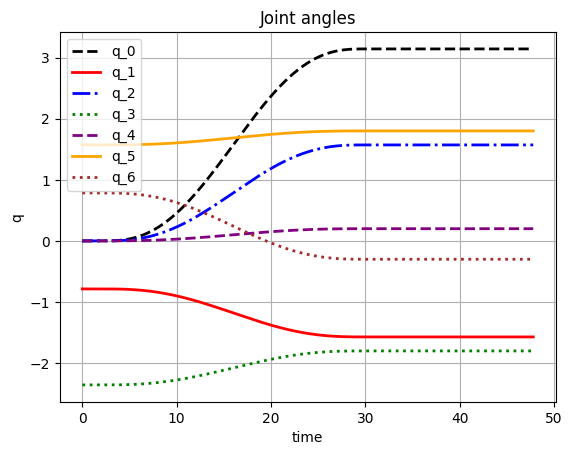

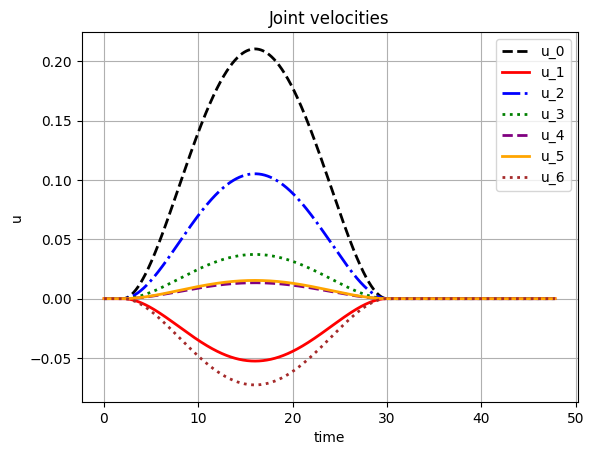

In [9]:

colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'brown'][:ARM_DOF]
linestyles = ['--', '-', '-.', ':', '--', '-', ':'][:ARM_DOF]

plt.figure(1)
for i in range(ARM_DOF):  # Loop over i = 0 to 5
    plt.plot(time_all, q_all[:, i], label=f'q_{i}', color=colors[i], linestyle=linestyles[i], linewidth=2)

plt.xlabel('time')
plt.ylabel('q')
plt.legend()
plt.title('Joint angles')
plt.grid()

plt.figure(2)
for i in range(ARM_DOF):  # Loop over i = 0 to 5
    plt.plot(time_all, u_all[:, i], label=f'u_{i}', color=colors[i], linestyle=linestyles[i], linewidth=2)


plt.xlabel('time')
plt.ylabel('u')
plt.legend()
plt.title('Joint velocities')
plt.grid()
# plt.show()
plt.show(block=False)  # Non-blocking display
# plt.pause(20)  # Pause for 2 seconds
# plt.close()  # Close the plot